In [10]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
# Cell 1: imports & basic config
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import time
import seaborn as sns
from qiskit_aer import AerSimulator
from pathlib import Path

# add repo root (parent of notebooks/) to sys.path
sys.path.append(str(Path.cwd().parent))
from lib.graphlib import GraphLib

# Notebook defaults
AER_BACKEND = AerSimulator()
QAOA_SHOTS = 1024  # simulator shots for validating angles
EDGE_PROB = 0.2
WEIGHT_RANGE = (1, 5)

# Sweep sizes (you can change / expand)
NS_SMALL = list(range(6, 12, 2))
NS_LARGE = list(range(22, 24, 2))
NS_ALL = NS_SMALL + NS_LARGE

# Repeats per size
REPEATS_SMALL = 5
REPEATS_LARGE = 3

# For plotting aesthetics
import seaborn as sns
sns.set_theme(context="talk", style="whitegrid")  # same as seaborn-talk

In [12]:
# Cell 2: helper to run one graph instance and return results as dict
def run_single_instance(n, edge_prob=EDGE_PROB, weight_range=WEIGHT_RANGE, shots=QAOA_SHOTS, compute_optimal=True):
    """
    Generate a random graph with n nodes and run:
      - classical approximations (random, local search)
      - qaoa p=1 analytic optimize + simulated validation (shots)
      - optional brute-force exact optimum if compute_optimal True
    Returns a dict with values and timings.
    """
    g = GraphLib()
    g.generate_random_graph(
        num_vertices=n, edge_prob=edge_prob, weight_range=weight_range, seed=None)

    out = {'n': n}
    # Classical random approx
    t0 = time.time()
    _, w_rand = g.max_cut_random(trials=2000)
    t_rand = time.time() - t0
    out.update({'rand_cut': w_rand, 'rand_time': t_rand})

    # Classical local search approx
    t0 = time.time()
    _, w_local = g.max_cut_local_search(iterations=200)
    t_local = time.time() - t0
    out.update({'local_cut': w_local, 'local_time': t_local})

    # Brute force optimal if allowed for small n
    if compute_optimal:
        t0 = time.time()
        _, w_opt = g.max_cut_bruteforce()
        t_opt = time.time() - t0
        out.update({'opt_cut': w_opt, 'opt_time': t_opt})
    else:
        out.update({'opt_cut': None, 'opt_time': None})

    # QAOA p=1: analytic optimization (fast)
    t0 = time.time()
    gamma_star, beta_star, val_star, _ = g.optimize_qaoa1_classical(
        grid_res=41, refine=True)
    t_qaoa_opt = time.time() - t0
    out.update({'qaoa_gamma': gamma_star, 'qaoa_beta': beta_star,
               'qaoa_analytic_val': val_star, 'qaoa_opt_time': t_qaoa_opt})

    # Validate via simulator (shots)
    t0 = time.time()
    res = g.qaoa1_expectation_simulated(
        gamma_star, beta_star, shots=shots, backend=AER_BACKEND)
    t_qaoa_sim = time.time() - t0
    # res includes 'expectation' (sampled average), 'best_cut' (best sample)
    out.update({
        'qaoa_sampled_expectation': res['expectation'],
        'qaoa_best_cut': res['best_cut'],
        'qaoa_counts': res['counts'],
        'qaoa_sim_time': t_qaoa_sim,
        'qaoa_shots': shots
    })
    return out

In [13]:
# Cell 3: sweep driver that runs multiple repeats per n and collects results
def sweep_ns(ns_list, repeats_small=REPEATS_SMALL, repeats_large=REPEATS_LARGE):
    rows = []
    for n in ns_list:
        repeats = repeats_small if n <= 20 else repeats_large
        print(f"Running n={n} with {repeats} repeats ...")
        for r in range(repeats):
            row = run_single_instance(n, edge_prob=EDGE_PROB, weight_range=WEIGHT_RANGE,
                                      shots=QAOA_SHOTS, compute_optimal=(n <= 20))
            row['repeat'] = r
            rows.append(row)
    df = pd.DataFrame(rows)
    return df


# Run the sweep (this will take time depending on NS_ALL and repeats)
df = sweep_ns(NS_ALL, repeats_small=REPEATS_SMALL, repeats_large=REPEATS_LARGE)

Running n=6 with 5 repeats ...
Running n=8 with 5 repeats ...
Running n=10 with 5 repeats ...
Running n=22 with 3 repeats ...


In [14]:
# Cell 4: quick peek at collected data (optional)
df.head()

,n,rand_cut,rand_time,local_cut,local_time,opt_cut,opt_time,qaoa_gamma,qaoa_beta,qaoa_analytic_val,qaoa_opt_time,qaoa_sampled_expectation,qaoa_best_cut,qaoa_counts,qaoa_sim_time,qaoa_shots,repeat
0,6,6,0.086720,6,0.000158,6.0,0.005987,0.843595,0.328148,5.128152,0.403951,5.065430,6,"{'000001': 1, '101010': 19, '110110': 22, '100...",0.367874,1024,0
1,6,10,0.114549,5,0.000103,10.0,0.001497,1.047258,0.392751,8.247595,0.154055,6.137695,10,"{'000101': 11, '101110': 7, '110010': 35, '001...",0.375595,1024,1
2,6,8,0.118405,8,0.000105,8.0,0.001528,1.047193,0.392649,6.598076,0.252924,6.132812,8,"{'101100': 2, '110100': 22, '000011': 39, '000...",0.285384,1024,2
3,6,1,0.115378,0,0.000085,1.0,0.001282,1.570796,0.392699,1.000000,0.113768,0.489258,1,"{'011110': 14, '010101': 20, '101101': 17, '11...",0.353207,1024,3
4,6,19,0.119360,19,0.000089,19.0,0.001252,0.677675,0.350095,13.855836,0.228353,10.124023,19,"{'011010': 28, '101000': 13, '010001': 18, '11...",0.289344,1024,4


In [15]:
# Cell 5: compute aggregated metrics per n and algorithm; compute approximation ratios
def compute_aggregates(df):
    # compute mean & std for cuts and times
    agg = df.groupby('n').agg({
        'opt_cut': ['mean', 'std', 'count'],
        'rand_cut': ['mean', 'std'],
        'local_cut': ['mean', 'std'],
        'qaoa_best_cut': ['mean', 'std'],
        'rand_time': ['mean', 'std'],
        'local_time': ['mean', 'std'],
        'qaoa_opt_time': ['mean', 'std'],
        'qaoa_sim_time': ['mean', 'std']
    })
    # flatten columns
    agg.columns = ['_'.join(col).strip() for col in agg.columns.values]
    agg = agg.reset_index()

    # compute approximation ratios:
    # - opt_over_local = opt_cut / local_cut  (if opt exists)
    # - opt_over_qaoa = opt_cut / qaoa_best_cut
    # - classical_over_quantum = local_cut / qaoa_best_cut (how classical compares to quantum)
    def safe_div(a, b):
        if a is None or b is None or b == 0:
            return None
        return a / b
    ratios = []
    for _, row in agg.iterrows():
        n = int(row['n'])
        opt_mean = row.get('opt_cut_mean', None)
        local_mean = row['local_cut_mean']
        qaoa_mean = row['qaoa_best_cut_mean']
        rand_mean = row['rand_cut_mean']
        ratios.append({
            'n': n,
            'opt_mean': opt_mean,
            'local_mean': local_mean,
            'rand_mean': rand_mean,
            'qaoa_mean': qaoa_mean,
            'opt_over_local': safe_div(opt_mean, local_mean) if opt_mean is not None else None,
            'opt_over_qaoa': safe_div(opt_mean, qaoa_mean) if opt_mean is not None else None,
            'local_over_qaoa': safe_div(local_mean, qaoa_mean),
            'rand_over_qaoa': safe_div(rand_mean, qaoa_mean),
            # times for plotting
            'local_time_mean': row['local_time_mean'],
            'qaoa_sim_time_mean': row['qaoa_sim_time_mean'],
            'opt_time_mean': row.get('opt_time_mean', None)
        })
    ratios_df = pd.DataFrame(ratios)
    return agg, ratios_df


agg_df, ratios_df = compute_aggregates(df)
agg_df.head(), ratios_df.head()

(    n  opt_cut_mean  opt_cut_std  opt_cut_count  rand_cut_mean  rand_cut_std  \
 0   6           8.8     6.610598              5       8.800000      6.610598   
 1   8          17.4     5.319774              5      17.400000      5.319774   
 2  10          26.4    12.054045              5      26.400000     12.054045   
 3  22           NaN          NaN              0      97.666667      7.767453   
 
    local_cut_mean  local_cut_std  qaoa_best_cut_mean  qaoa_best_cut_std  \
 0             7.6       7.021396            8.800000           6.610598   
 1            14.6       5.128353           17.200000           5.263079   
 2            20.8      11.606033           26.400000          12.054045   
 3            83.0       8.717798           95.666667           9.504385   
 
    rand_time_mean  rand_time_std  local_time_mean  local_time_std  \
 0        0.110882       0.013656         0.000108        0.000029   
 1        0.131466       0.032326         0.000510        0.000805   
 

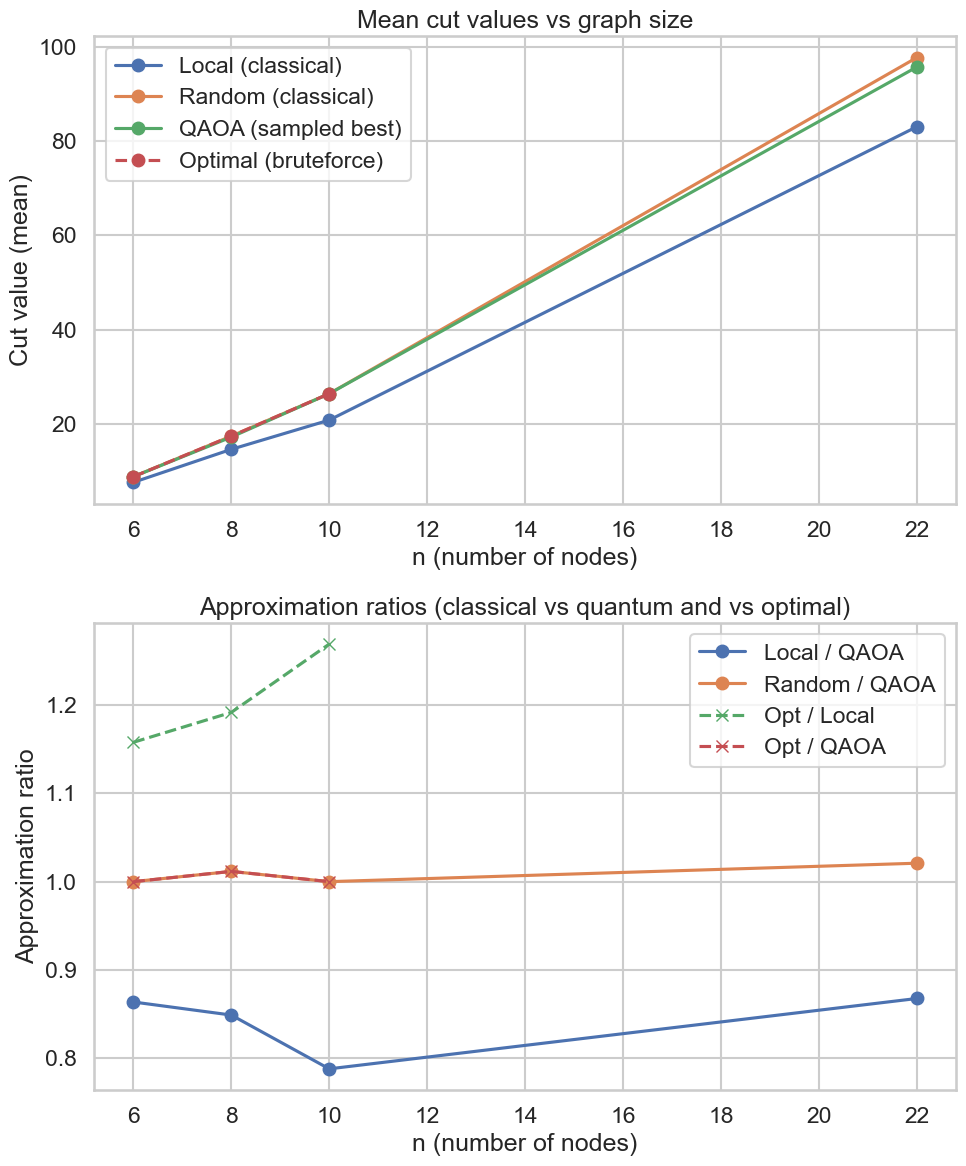

In [16]:
# Cell 6: plots for cut means and approximation ratios
def plot_cuts_and_ratios(agg_df, ratios_df):
    fig, axes = plt.subplots(2, 1, figsize=(10, 12))

    # Plot mean cut values
    ax = axes[0]
    ax.plot(agg_df['n'], agg_df['local_cut_mean'],
            label='Local (classical)', marker='o')
    ax.plot(agg_df['n'], agg_df['rand_cut_mean'],
            label='Random (classical)', marker='o')
    ax.plot(agg_df['n'], agg_df['qaoa_best_cut_mean'],
            label='QAOA (sampled best)', marker='o')
    if 'opt_cut_mean' in agg_df.columns:
        ax.plot(agg_df['n'], agg_df['opt_cut_mean'],
                label='Optimal (bruteforce)', marker='o', linestyle='--')
    ax.set_xlabel('n (number of nodes)')
    ax.set_ylabel('Cut value (mean)')
    ax.set_title('Mean cut values vs graph size')
    ax.legend()
    ax.grid(True)

    # Plot approximation ratios
    ax2 = axes[1]
    ax2.plot(ratios_df['n'], ratios_df['local_over_qaoa'],
             label='Local / QAOA', marker='o')
    ax2.plot(ratios_df['n'], ratios_df['rand_over_qaoa'],
             label='Random / QAOA', marker='o')
    # opt_over_local and opt_over_qaoa exist only where computed (n<=20)
    if 'opt_over_local' in ratios_df.columns and ratios_df['opt_over_local'].notnull().any():
        ax2.plot(ratios_df['n'], ratios_df['opt_over_local'],
                 label='Opt / Local', marker='x', linestyle='--')
        ax2.plot(ratios_df['n'], ratios_df['opt_over_qaoa'],
                 label='Opt / QAOA', marker='x', linestyle='--')
    ax2.set_xlabel('n (number of nodes)')
    ax2.set_ylabel('Approximation ratio')
    ax2.set_title('Approximation ratios (classical vs quantum and vs optimal)')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()


plot_cuts_and_ratios(agg_df, ratios_df)

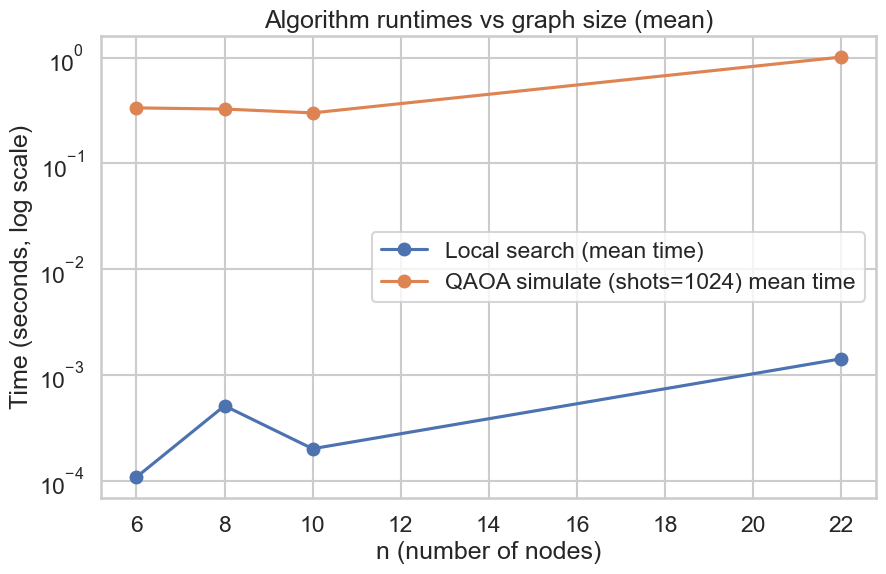

In [17]:
# Cell 7: runtimes comparison (mean)
def plot_runtimes(agg_df):
    plt.figure(figsize=(10, 6))
    plt.plot(agg_df['n'], agg_df['local_time_mean'],
             label='Local search (mean time)', marker='o')
    plt.plot(agg_df['n'], agg_df['qaoa_sim_time_mean'],
             label=f'QAOA simulate (shots={QAOA_SHOTS}) mean time', marker='o')
    if 'opt_time_mean' in agg_df.columns:
        plt.plot(agg_df['n'], agg_df['opt_time_mean'],
                 label='Bruteforce optimal (mean time)', marker='o', linestyle='--')
    plt.yscale('log')  # times may vary widely; log scale helps
    plt.xlabel('n (number of nodes)')
    plt.ylabel('Time (seconds, log scale)')
    plt.title('Algorithm runtimes vs graph size (mean)')
    plt.legend()
    plt.grid(True)
    plt.show()


plot_runtimes(agg_df)

In [21]:
# Cell 8: save raw and aggregated results (optional)
df.to_csv('../data/maxcut_simulation_raw_results.csv', index=False)
agg_df.to_csv('../data/maxcut_simulation_aggregates.csv', index=False)
ratios_df.to_csv('../data/maxcut_simulation_ratios.csv', index=False)
print("Saved CSVs: raw, aggregates, ratios.")

Saved CSVs: raw, aggregates, ratios.
